In [34]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")
print("Path to dataset files:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path = os.path.join(path, "sprites.npy")

# Load dataset
labels = np.load(labels_path)
data = np.load(data_path)
print("Shape: ", data.shape)

# ============================================
# HYPERPARAMETERS
# ============================================
workers = 2
batch_size = 64
nc = 3  # number of color channels
z_dim = 100  # latent vector size
num_epochs = 10  # INCREASED from 5
lr = 0.0002
beta1 = 0.5
ngpu = 1
ngf = 64  # INCREASED from 32
ndf = 64  # INCREASED from 32
num_classes = 5  # number of classes for conditional GAN

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ============================================
# PREPARE DATA
# ============================================
images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

# NORMALIZE to [-1, 1] for Tanh
images_tensor = (images_tensor / 255.0) * 2 - 1
print("Normalized to range:", images_tensor.min().item(), "to", images_tensor.max().item())

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("Device: ", device)

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Normalized to range: -1.0 to 1.0
Device:  cuda:0


Batch shapes: torch.Size([32, 3, 16, 16]) torch.Size([32, 5])


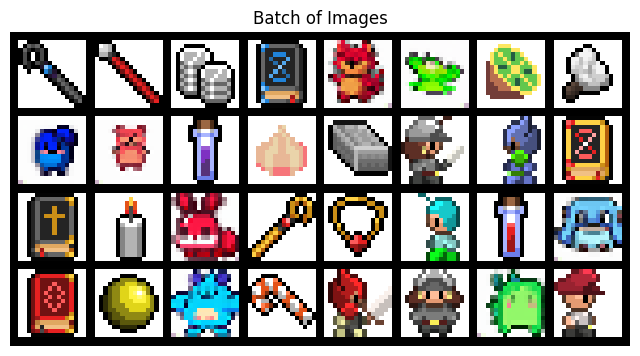

In [36]:
real_batch = next(iter(loader))
images, labels = real_batch
print("Batch shapes:", images.shape, labels.shape)

grid = vutils.make_grid(images, padding=2, normalize=True)
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

#### DC + Conditional GAN

Hyperparameter

Weight Initialization

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

In [38]:
class Generator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        # label embedding
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.gen = nn.Sequential(
            # input: (z_dim + num_classes) x 1 x 1
            nn.ConvTranspose2d(
                in_channels=z_dim + num_classes,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # 4x4 → 8x8
            nn.ConvTranspose2d(
                ngf * 8, ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 8x8 → 16x16
            nn.ConvTranspose2d(
                ngf * 4, nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # labels → embedding
        label_emb = self.label_emb(labels)

        # reshape to match noise (B, C, 1, 1)
        label_emb = label_emb.unsqueeze(2).unsqueeze(3)

        # concatenate noise + label
        x = torch.cat([noise, label_emb], dim=1)

        return self.gen(x)

In [39]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        # label embedding → map label to 16x16
        self.label_emb = nn.Embedding(num_classes, 16 * 16)

        self.disc = nn.Sequential(
            # input: (nc + 1) x 16 x 16
            nn.Conv2d(
                in_channels=nc + 1,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8
            nn.Conv2d(
                ndf, ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 4x4 → 1x1
            nn.Conv2d(
                ndf * 2, 1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        # labels → embedding
        label_map = self.label_emb(labels)

        # reshape to (B, 1, 16, 16)
        label_map = label_map.view(labels.size(0), 1, 16, 16)

        # concatenate image + label
        x = torch.cat([images, label_map], dim=1)

        return self.disc(x)

In [40]:
netG = Generator(ngpu, num_classes).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

netD = Discriminator(ngpu, num_classes).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Generator(
  (label_emb): Embedding(5, 5)
  (gen): Sequential(
    (0): ConvTranspose2d(105, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
Discriminator(
  (label_emb): Embedding(5, 256)
  (disc): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU

Loss and Optimizer

In [41]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# ============================================
# INITIALIZE TRAINING VARIABLES
# ============================================
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

G_losses = []
D_losses = []
img_list = []

# CHANGED: Remove label smoothing initially
real_label = 1.0
fake_label = 0.0

Training Loop

In [42]:
print("Starting Training Loop...")

iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        netD.zero_grad()

        # Real batch
        real_cpu, real_labels = data
        real_cpu = real_cpu.to(device)
        b_size = real_cpu.size(0)

        # Convert one-hot labels to class indices
        real_labels = real_labels.to(device)
        if real_labels.dim() > 1 and real_labels.size(1) == num_classes:
            real_labels = torch.argmax(real_labels, dim=1)
        real_labels = real_labels.long()

        # Train with REAL images
        label = torch.full((b_size,), real_label, dtype=torch.float32, device=device)
        output = netD(real_cpu, real_labels).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with FAKE images
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake = netG(noise, real_labels)
        
        label.fill_(fake_label)
        output = netD(fake.detach(), real_labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        netG.zero_grad()

        label.fill_(real_label)
        output = netD(fake, real_labels).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        ############################
        # Logs
        ############################
        if i % 50 == 0:
            print(
                f"[{epoch+1}/{num_epochs}][{i}/{len(loader)}] "
                f"Loss_D: {errD.item():.4f} "
                f"Loss_G: {errG.item():.4f} "
                f"D(x): {D_x:.4f} "
                f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
            )

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        ############################
        # Visualization
        ############################
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(loader) - 1)):
            with torch.no_grad():
                fixed_labels = torch.randint(0, num_classes, (64,), device=device).long()
                fake_vis = netG(fixed_noise, fixed_labels).detach().cpu()

            img_list.append(vutils.make_grid(fake_vis, padding=2, normalize=True))

        iters += 1

print("Training Complete!")

Starting Training Loop...
[1/10][0/2794] Loss_D: 1.4413 Loss_G: 0.6922 D(x): 0.6064 D(G(z)): 0.5883/0.5086
[1/10][50/2794] Loss_D: 0.8967 Loss_G: 1.4928 D(x): 0.5797 D(G(z)): 0.2757/0.2284
[1/10][100/2794] Loss_D: 0.7971 Loss_G: 1.5638 D(x): 0.6469 D(G(z)): 0.2825/0.2224
[1/10][150/2794] Loss_D: 0.5889 Loss_G: 1.7615 D(x): 0.7523 D(G(z)): 0.2466/0.1810
[1/10][200/2794] Loss_D: 0.4369 Loss_G: 2.0495 D(x): 0.7889 D(G(z)): 0.1719/0.1345
[1/10][250/2794] Loss_D: 0.6940 Loss_G: 1.6749 D(x): 0.7167 D(G(z)): 0.2780/0.2116
[1/10][300/2794] Loss_D: 0.7528 Loss_G: 1.7120 D(x): 0.6645 D(G(z)): 0.2587/0.1937
[1/10][350/2794] Loss_D: 0.8776 Loss_G: 1.7455 D(x): 0.5803 D(G(z)): 0.2441/0.1948
[1/10][400/2794] Loss_D: 0.7264 Loss_G: 1.6864 D(x): 0.6785 D(G(z)): 0.2577/0.2015
[1/10][450/2794] Loss_D: 0.6358 Loss_G: 1.7833 D(x): 0.7760 D(G(z)): 0.2945/0.1843
[1/10][500/2794] Loss_D: 0.8411 Loss_G: 1.3709 D(x): 0.6514 D(G(z)): 0.3098/0.2719
[1/10][550/2794] Loss_D: 0.9229 Loss_G: 1.4423 D(x): 0.5948 D(G(

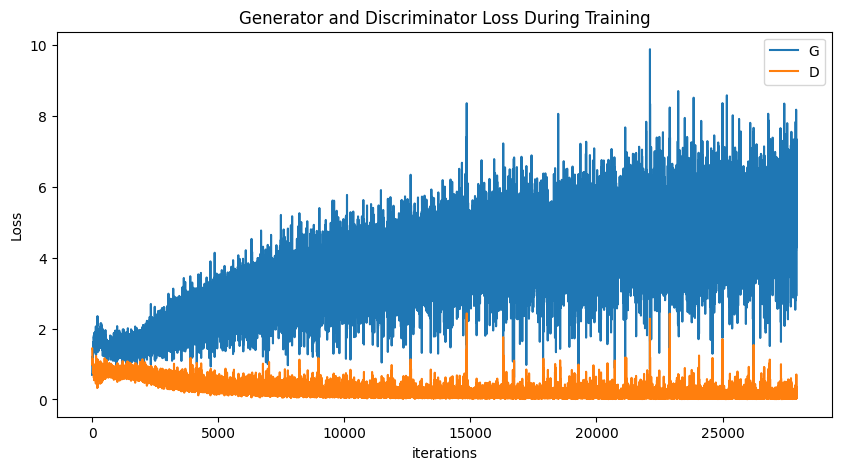

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

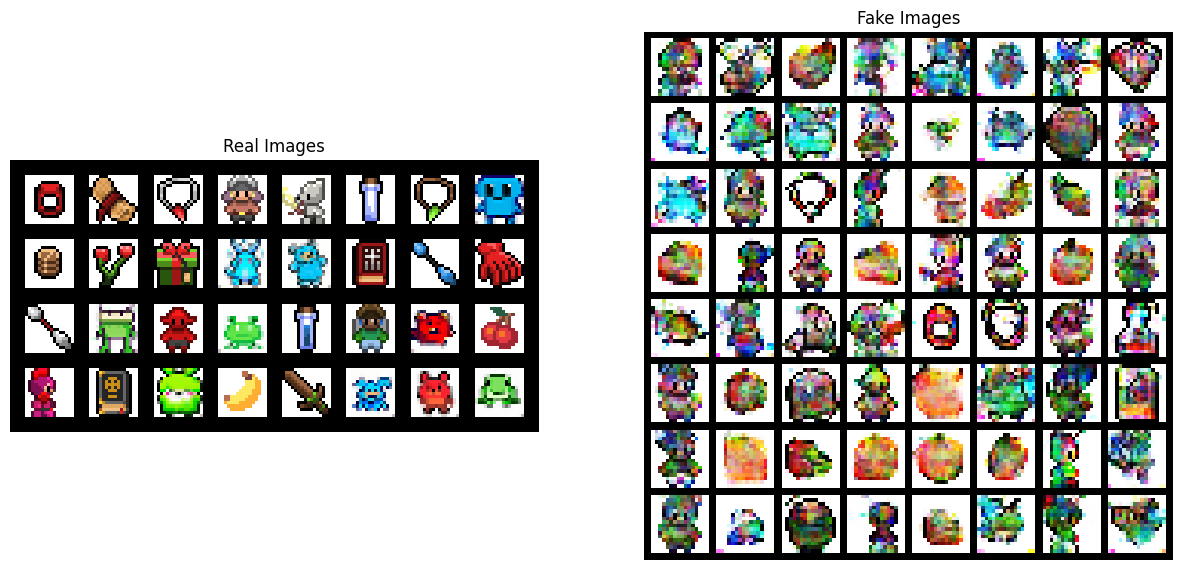

In [44]:
# ============================================
real_batch = next(iter(loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

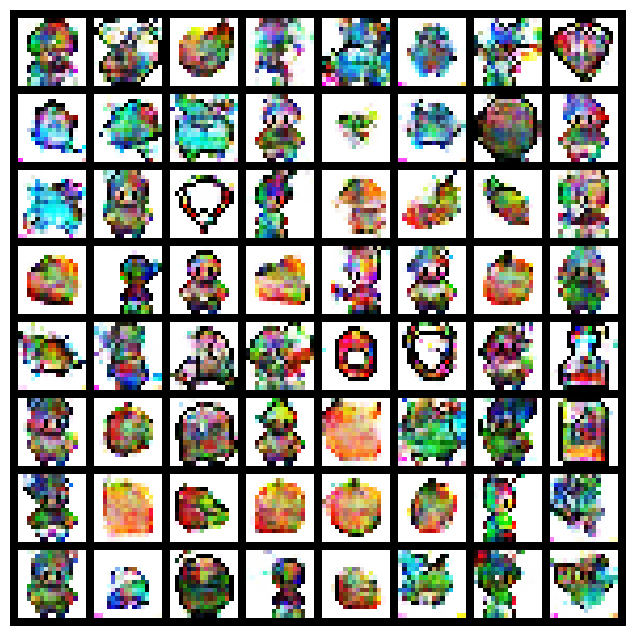

In [45]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())